In [128]:
import os
from langchain.chat_models import init_chat_model

gemini_key = "CHANE: your API key and the correct provider"
os.environ["GOOGLE_API_KEY"] = gemini_key

model = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0)

E0000 00:00:1759758868.800216 59967959 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


# Load the documents

In [53]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    # "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    # "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/" 
    #CHANGE: Uncomment and even add more documents to embedd, I am using a free tier and run out of Requests per minute quota
]

docs = [WebBaseLoader(url).load() for url in urls]

In [54]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

# Split and embedd the documents

In [55]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(length_function=len).from_tiktoken_encoder(chunk_size=100, chunk_overlap=50)

doc_splits = text_splitter.split_documents(docs_list)

In [56]:
doc_splits[0].page_content

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

In [66]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

vectorstore = InMemoryVectorStore.from_documents(documents=doc_splits[:100], #CHANGE: I embedd only 100 documents due to the quota limitation
                                                 embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001"))

retriever = vectorstore.as_retriever()

E0000 00:00:1759745908.097130 59967959 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759745908.098281 59967959 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [74]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts"
)

In [132]:
retriever_tool.invoke({"query": "reward hacking"})

'Why does Reward Hacking Exist?#\n\nHacking RL Environment#\n\nLet’s Define Reward Hacking#\nReward shaping in RL is challenging. Reward hacking occurs when an RL agent exploits flaws or ambiguities in the reward function to obtain high rewards without genuinely learning the intended behaviors or completing the task as designed. In recent years, several related concepts have been proposed, all referring to some form of reward hacking:\n\nReward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.'

# Generate a query

In [129]:
from langgraph.graph import MessagesState

def generate_query_or_respond(state: MessagesState):
    response = model.bind_tools([retriever_tool]).invoke(state["messages"])
    return {"messages": [response]}

In [130]:
input = {"messages": [{"role": "user", "content": "What does Lilian Weng say about types of reward hacking?"}]}
state = generate_query_or_respond(input)

In [131]:
state["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (b4b1f591-9297-4840-a7ed-2b73deb88d45)
 Call ID: b4b1f591-9297-4840-a7ed-2b73deb88d45
  Args:
    query: reward hacking


# Grade documents

In [133]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Relevance score: 'yes if relevant, 'no' if not relevant")

grader_model = model.with_structured_output(GradeDocuments)

In [174]:
def grade_documents(state: MessagesState) -> Literal["generate_answer", "rewrite_question"]:
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = grader_model.invoke([{"role": "user", "content": prompt}])

    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    return "rewrite_question"

In [136]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite question'

In [137]:
input = {
    "messages": convert_to_messages([
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?"
        },
        {
            "role": "assistant",
            "content": "",
            "tool_calls": [
                {
                    "id": "1",
                    "name": "retrieve_blog_posts",
                    "args": {"query": "types of reward hacking"}
                }
            ]
        },
        {
            "role": "tool",
            "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
            "tool_call_id": 1
        }
    ])
}
grade_documents(input)

'generate answer'

# Rewrite Question

In [145]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate a single improved question and only the question:"
)

def rewrite_question(state: MessagesState):
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [146]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What types of reward hacking does Lilian Weng identify?


# Generate an answer

In [150]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

def generate_answer(state: MessagesState):
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": response.content}

In [159]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response

{'messages': 'Lilian Weng states that reward hacking can be categorized into two types. These types are environment or goal misspecification, and reward tampering.'}

In [158]:
response["messages"]

'Lilian Weng states that reward hacking can be categorized into two types. These types are environment or goal misspecification, and reward tampering.'

# Assemble the graph

In [209]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

workflow.add_node(generate_query_or_respond)
workflow.add_node("retriever", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")
workflow.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {
        "tools": "retriever",
        END: END #To visuallise the graph the key must be a string -> "END": END, otherwise it is invalid mermaid syntax
    },
)
workflow.add_conditional_edges(
    "retriever",
    grade_documents
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

graph_rag = workflow.compile()

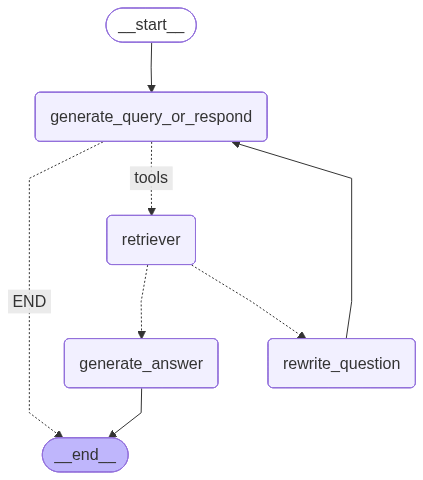

In [208]:
from IPython.display import Image, display

display(Image(graph_rag.get_graph().draw_mermaid_png())) #The first

In [210]:
for chunk in graph_rag.stream({
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?"
        }
    ]
}):

    for node, update in chunk.items():
        print("Update from node", node)
        if hasattr(update["messages"][-1], "pretty_print"):
            update["messages"][-1].pretty_print()
        else:
            print(update["messages"][-1])
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (8b337495-305d-4d6d-8457-1373708ff85c)
 Call ID: 8b337495-305d-4d6d-8457-1373708ff85c
  Args:
    query: reward hacking types



Update from node retriever
================================= Tool Message =================================
Name: retrieve_blog_posts

Why does Reward Hacking Exist?#

Let’s Define Reward Hacking#
Reward shaping in RL is challenging. Reward hacking occurs when an RL agent exploits flaws or ambiguities in the reward function to obtain high rewards without genuinely learning the intended behaviors or completing the task as designed. In recent years, several related concepts have been proposed, all referring to some form of reward hacking:

Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning o